# 13대 젠더 관련 의안 분석

### 1988.05.30 ~ 1992.05.29 / 노태우 정부

In [35]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
import hanja
from krwordrank.hangle import normalize
%matplotlib inline

In [36]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


2020-09-29 21:03:03,509 : INFO : Generating new fontManager, this may take some time...
2020-09-29 21:03:04,155 : INFO : Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-29 21:03:04,315 : INFO : Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-29 21:03:04,317 : INFO : Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str


In [37]:
bill_df = pd.read_csv('/Users/harampark/Documents/research/gender-bill-analysis/data/selenium-data/13대 국회 의안정보.csv', 
                      parse_dates=['제안일자', '의결일자'], index_col=0).reset_index()
bill_df.head()

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,131436,국회의원선거법중개정법률안(김윤환의원등 10인 외 279인),1991-12-16,의원,1991-12-17,수정가결,제13대 (1988~1992) 제156회,['■ 제안이유이 改正法律案은“돈 안쓰는 選擧風土”를 造成하기 위하여 選擧事犯의 刑...,내무위원회,"['김윤환', '강신옥', '강재섭', '김원기', '박상천', '박실', '윤재기..."
1,131433,교육법중개정법률안(함종한의원 외 20인),1991-12-11,의원,1992-05-29,임기만료폐기,제13대 (1988~1992) 제156회,['■ 제안이유우리 産業이 겪고 있는 人力難을 해소하고 장기적으로 國家産業 發展에 ...,교육체육청소년위원회,"['함종한', '권오석', '김일동', '박관용', '박승재', '박용만', '신경..."
2,131432,산업기술교육육성법안(함종한의원 외 20인),1991-12-11,의원,1992-05-29,임기만료폐기,제13대 (1988~1992) 제156회,"['■ 제안이유産業技術敎育의 振興發展을 위한 國家와 産業體의 投資促進,産學協同의 實...",교육체육청소년위원회,"['함종한', '권오석', '김일동', '박관용', '박승재', '박용만', '신경..."
3,131430,정치자금에관한법률중개정법률안(김윤환의원등 8인 외 211인),1991-12-10,의원,1991-12-17,수정가결,제13대 (1988~1992),[],내무위원회,"['김윤환', '강신옥', '강재섭', '강재섭', '오한구', '윤재기', '이자..."
4,131429,국회의원선거법중개정법률안(김윤환의원등 8인 외 211인),1991-12-10,의원,1992-05-29,임기만료폐기,제13대 (1988~1992) 제156회,['■ 제안이유墮落이나 混亂誘發의 우려가 없는 選擧運動方法은 이를 확대하고 國民의 ...,내무위원회,"['김윤환', '강신옥', '강재섭', '강재섭', '오한구', '윤재기', '이자..."


In [38]:
def preprocessing(text): 
    text = text.replace('■ 제안이유', ' ').replace('■ 주요골자', ' ').replace('■ 기타사항', ' ')
    text = text.replace('■ 위원회 수정사항□ 수정이유',' ').replace('■ 제안경위',' ').replace('[',' ').replace(']',' ')
    text = text.replace('녀성', '여성').replace('로동', '노동').replace('륜리','윤리').replace('녀비','여비')
    text = text.replace("'",' ').replace('女','여').replace('략취','약취')
    return text

def clean_name(text): 
    text = text.split('(')[0]
    return str(text).strip()

In [39]:
%time bill_df['제안이유'] = bill_df['제안이유'].apply(lambda x: hanja.translate(x, 'substitution'))
%time bill_df['제안이유'] = bill_df['제안이유'].apply(preprocessing)
%time bill_df['의안명'] = bill_df['의안명'].apply(clean_name)

CPU times: user 3.46 s, sys: 31.4 ms, total: 3.49 s
Wall time: 3.55 s
CPU times: user 11.9 ms, sys: 554 µs, total: 12.5 ms
Wall time: 13.6 ms
CPU times: user 1.13 ms, sys: 47 µs, total: 1.18 ms
Wall time: 1.15 ms


In [40]:
bill_df.head(1)

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,131436,국회의원선거법중개정법률안,1991-12-16,의원,1991-12-17,수정가결,제13대 (1988~1992) 제156회,이 개정법률안은“돈 안쓰는 선거풍토”를 조성하기 위하여 선거사범의 형량을 상향...,내무위원회,"['김윤환', '강신옥', '강재섭', '김원기', '박상천', '박실', '윤재기..."


## 젠더 관련 의안만 추리기

In [41]:
# 딱히 특정할만한 소관위원회는 없음 
bill_df['소관위원회'].unique()

array(['내무위원회', '교육체육청소년위원회', '재무위원회', '보건사회위원회', '경제과학위원회', '건설위원회',
       '노동위원회', '농림수산위원회', '법제사법위원회', '국방위원회', '교통체신위원회', '동력자원위원회',
       '상공위원회', '행정위원회', '외무통일위원회', '문화공보위원회', '국회운영위원회', '문교체육위원회',
       '대전국제무역산업박람지원특별위원회', '문교공보위원회', '민주발전을위한법률개폐특별위원회',
       '5·18광주민주화운동특별위원회', '올림픽특별위원회', '국회법개정특별위원회'], dtype=object)

In [42]:
keyword = r'.*(여성|성범죄|성역할|남녀|호주|보육|모자|육아|가족|부녀자|가부장|강간|간통죄|\
                정조|모성|성희롱|윤락|양성평등|양성 평등|성접대|낙태|가정폭력).*'
gender = bill_df[bill_df['의안명'].str.match(keyword) |
           bill_df['제안이유'].str.match(keyword, flags=re.MULTILINE)]
gender = gender.reset_index()
gender = gender.drop('index',1)
gender.shape

(52, 10)

In [43]:
len(gender)

52

In [44]:
for ind in range(len(gender)): 
    print(gender.loc[ind,'의안번호'])
    print(gender.loc[ind, '제안이유'])

131436
   이 개정법률안은“돈 안쓰는 선거풍토”를 조성하기 위하여 선거사범의 형량을 상향조정하고 기부행위 제한규정의 강화,유급선거운동원제도의 폐지,수동적으로 金품을 수령한 유권자의 자수시 특례,선거사범의 공소시효연장, 선거사범 재판기간 단축등 실질적 조치를 강구하는 한편, 선거공영제를 확대하기 위하여 노력하였다.“후보자와 정당의 알릴 기회”를 확대하기 위하여 정당연설회를 부활하고 방송시설설치에 의한 후보자의 경력방송, 공개된 장소에서의 선거운동방법 등을 신설하고 국민의 법감정에 맞지 아니하는 비현실적인 규제사항을완화하였다.다른 한편 투표가치의 등가성을 확보하기 위하여 현행 국회의원 정수 299인을 늘리지 않은채 13개 지역구를 증설하고, 제1당이 지역구에서 의석수의 과반수를 얻지 못할 경우 전국구의석의 2분의1을 우선 배분하는 제도를폐지하고 군소정당에 대하여 의회진출기회를 용이하게 하였다.그밖에 선거기간의 단축, 정당추천 후보자와 무소속후보자의 형평을 도모키 위한 기탁金 액수의 차별철폐, 투개표 참관인수에서의 불균형 제거등 현행제도상의 일부 미비점을 개선·보완하였다.우리는 이 개정법률안의 통과로 돈이 적게 들고 유권자의 알 기회가 확대되는 새로운 선거풍토가 조성되기를기대한다. 1. 의원의 정수를 현행의 지역구 및 전국구의원정수를 합한 299인으로 정수화함으로써 전국구의원정수를 지역구의원정수의 증감에 비례하지 아니하도록 함(안 제14조)2. 구·시·읍·면의 장의 착오등의 사유로 인하여 정당한 선거권자가 선거인명부에서 누락된 것이 발견된 때에는 선거인명부에 대한 이의신청기간 이 경과하였더라도 선거인명부가 확정될 때까지는 당해 선거권자 또는 구·시·읍·면의 장의 신청에 의하여 이를 구제할 수 있도록 함(안 제23조의2)3. 선거운동기간을 18일에서 17일로 단축하고, 후보자의 등록기간을 5일이내에서 3일이내로 단축함(안 제27조제1항 및 제99조제3항)4. 지역구후보자의 기탁金을 종전에는 정당추천후보자는 1천만원,무소속후보자는 2천만원으로 하던 것을 균등하게

In [45]:
remove_bill = [131436, 131429, 131427, 131421, 131420, 131364, 131301, 131328, 131299,  131298, 131279, 131239, 130174, 130172, 130069, 131066, 
               131238, 131170, 131130, 131125, 131105, 130862, 130849, 130823, 130620, 130577, 130550, 130537, 130532, 130187, 130058, 
               131094, 131091, 131080, 131026, 130998, 130797, 130717, 130715, 130711, 130664, 130602, 130490, 130278, 130267, 130129,
               130472, 130433, 130427, 130430, 130394, 130362, 130427, 130214, 130208, 130172, 130160, 130074, 130064, 130057, 130042, 130039]
gender = gender[~gender['의안번호'].isin(remove_bill)]
gender = gender.reset_index()
gender = gender.drop('index',1)
print(gender.shape)

(17, 10)


In [46]:
len(remove_bill)

62

In [47]:
gender.to_csv('13th-gender-bill.csv',encoding='utf-8-sig')

## Gender bill 출력하기

In [49]:
gender = pd.read_csv('13th-gender-bill.csv', encoding='utf-8-sig')
gender = gender.drop('Unnamed: 0',1)
gender.head()

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,131131,소득세법중개정법률안,1990-12-17,위원장,1990-12-18,원안가결,제13대 (1988~1992) 제151회,"정부제출,柳인학·강金식·금봉욱·林춘원·李경재·허만기·홍영기의원외64인 발의,1...",재무위원회,[]
1,131126,특정범죄가중처벌등에관한법률중개정법률안,1990-12-17,위원장,1990-12-18,원안가결,제13대 (1988~1992) 제151회,1989.11.21과 1990.10.8 정부에서 제출한 각특정범죄가중처벌등에관...,법제사법위원회,[]
2,131059,영·유아의보호·교육에관한법률안,1990-11-20,의원,1990-12-18,수정가결,제13대 (1988~1992) 제151회,현대사회의 산업화에 따른 여성의 사회참여 증가 및 가족구조의 핵가족화에 의한 ...,보건사회위원회,"['신영순', '김장숙', '이윤자', '김문기', '김인영', '김일동', '김한..."
3,131055,특정강력범죄의처벌에관한특례법안,1990-11-20,의원,1990-12-18,수정가결,제13대 (1988~1992) 제151회,반인륜적이고 반사회적인 흉악범죄로서 가정과 사회질서를 침해하는 특정강력범죄에 ...,법제사법위원회,"['윤재기', '강우혁', '강재섭', '고세진', '구자춘', '김근수', '김일..."
4,131006,특정범죄가중처벌등에관한법률중개정법률안,1990-10-08,정부,1990-12-18,대안반영폐기,제13대 (1988~1992) 제151회,민생치안확립에 기여하게 하기 위하여 흉기 등을 휴대한 강간 등 행위에 대하여 ...,법제사법위원회,[]


In [51]:
proclaim_list = ['원안가결', '수정가결']
reject_list = ['임기만료폐기', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기','계류']

gender.loc[gender['의결결과'].isin(proclaim_list), '법률공포여부'] = '공포'
gender.loc[gender['의결결과'].isin(reject_list), '법률공포여부'] = '미공포'

In [52]:
gender['법률공포여부'].value_counts()

공포     9
미공포    8
Name: 법률공포여부, dtype: int64

In [55]:
def proornot_vis(df, name): 
    plt.figure(figsize = (5,5))
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = '법률공포여부', data = df, 
              palette = 'magma')

    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')

    plt.title(f'{name} 관련 의안 공포 여부')
    plt.show()

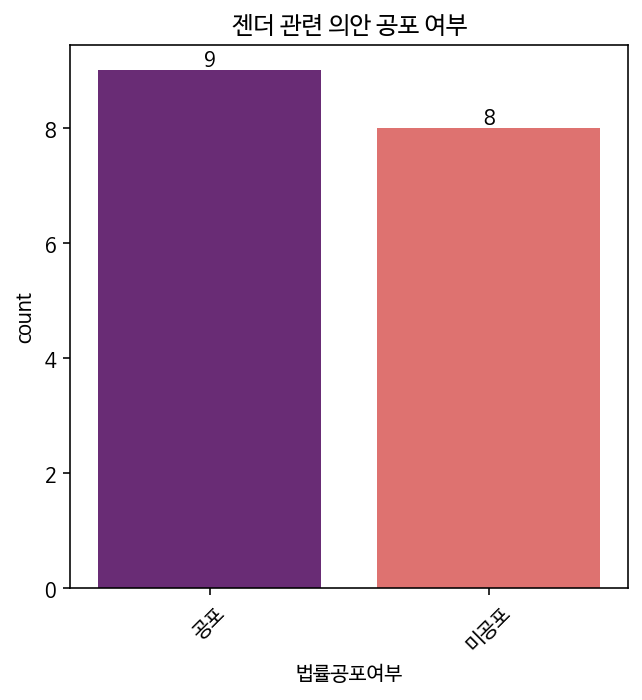

In [56]:
proornot_vis(gender, '젠더')

## wordcloud 시각화

In [14]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명','보장하',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [15]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [16]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 7.75 ms, sys: 672 µs, total: 8.42 ms
Wall time: 9.02 ms


In [17]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [18]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 17 s, sys: 415 ms, total: 17.4 s
Wall time: 6.3 s


0    [소득세법중개정법률, 정부제출, 인학, 금봉욱, 춘원, 경재, 허만기, 홍영기의원외...
1    [특정범죄가중처벌등에관한법률중개정법률안, 정부, 제출, 각특정범죄가중처벌등에관한법률...
2    [유아의보호, 교육에관한법률안, 현대사회, 산업화, 여성, 사회참여, 가족구조, 핵...
Name: tokens, dtype: object

In [19]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 29.5 ms, sys: 2.05 ms, total: 31.6 ms
Wall time: 20 ms


In [20]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [21]:
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=0, workers=4, iter=100, sg=0)

2020-09-29 20:13:10,715 : INFO : collecting all words and their counts
2020-09-29 20:13:10,717 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-29 20:13:10,719 : INFO : collected 1566 word types from a corpus of 3730 raw words and 17 sentences
2020-09-29 20:13:10,720 : INFO : Loading a fresh vocabulary
2020-09-29 20:13:10,728 : INFO : effective_min_count=0 retains 1566 unique words (100% of original 1566, drops 0)
2020-09-29 20:13:10,731 : INFO : effective_min_count=0 leaves 3730 word corpus (100% of original 3730, drops 0)
2020-09-29 20:13:10,739 : INFO : deleting the raw counts dictionary of 1566 items
2020-09-29 20:13:10,739 : INFO : sample=0.001 downsamples 50 most-common words
2020-09-29 20:13:10,745 : INFO : downsampling leaves estimated 3392 word corpus (91.0% of prior 3730)
2020-09-29 20:13:10,749 : INFO : estimated required memory for 1566 words and 100 dimensions: 2035800 bytes
2020-09-29 20:13:10,750 : INFO : resetting layer weights
2020-09-

2020-09-29 20:13:11,373 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-29 20:13:11,376 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-29 20:13:11,378 : INFO : EPOCH - 15 : training on 3730 raw words (3387 effective words) took 0.0s, 331132 effective words/s
2020-09-29 20:13:11,384 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-29 20:13:11,387 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-29 20:13:11,390 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-29 20:13:11,393 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-29 20:13:11,396 : INFO : EPOCH - 16 : training on 3730 raw words (3377 effective words) took 0.0s, 260042 effective words/s
2020-09-29 20:13:11,409 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-29 20:13:11,412 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-

2020-09-29 20:13:11,676 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-29 20:13:11,679 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-29 20:13:11,681 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-29 20:13:11,683 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-29 20:13:11,685 : INFO : EPOCH - 32 : training on 3730 raw words (3403 effective words) took 0.0s, 234768 effective words/s
2020-09-29 20:13:11,690 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-29 20:13:11,692 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-29 20:13:11,694 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-29 20:13:11,697 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-29 20:13:11,698 : INFO : EPOCH - 33 : training on 3730 raw words (3396 effective words) took 0.0s, 400278 effective words/s
2020-09-

2020-09-29 20:13:11,916 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-29 20:13:11,918 : INFO : EPOCH - 48 : training on 3730 raw words (3392 effective words) took 0.0s, 314181 effective words/s
2020-09-29 20:13:11,927 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-29 20:13:11,930 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-29 20:13:11,933 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-29 20:13:11,935 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-29 20:13:11,937 : INFO : EPOCH - 49 : training on 3730 raw words (3382 effective words) took 0.0s, 266536 effective words/s
2020-09-29 20:13:11,948 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-29 20:13:11,949 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-29 20:13:11,951 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-

2020-09-29 20:13:12,187 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-29 20:13:12,188 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-29 20:13:12,189 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-29 20:13:12,191 : INFO : EPOCH - 65 : training on 3730 raw words (3389 effective words) took 0.0s, 418236 effective words/s
2020-09-29 20:13:12,199 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-29 20:13:12,205 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-29 20:13:12,206 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-29 20:13:12,209 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-29 20:13:12,210 : INFO : EPOCH - 66 : training on 3730 raw words (3408 effective words) took 0.0s, 244796 effective words/s
2020-09-29 20:13:12,217 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-

2020-09-29 20:13:12,434 : INFO : EPOCH - 81 : training on 3730 raw words (3417 effective words) took 0.0s, 248585 effective words/s
2020-09-29 20:13:12,443 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-29 20:13:12,450 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-29 20:13:12,455 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-29 20:13:12,456 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-29 20:13:12,463 : INFO : EPOCH - 82 : training on 3730 raw words (3410 effective words) took 0.0s, 147710 effective words/s
2020-09-29 20:13:12,475 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-29 20:13:12,478 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-29 20:13:12,483 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-29 20:13:12,485 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-

2020-09-29 20:13:12,706 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-29 20:13:12,709 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-29 20:13:12,710 : INFO : EPOCH - 98 : training on 3730 raw words (3382 effective words) took 0.0s, 468080 effective words/s
2020-09-29 20:13:12,718 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-29 20:13:12,719 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-29 20:13:12,720 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-29 20:13:12,722 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-29 20:13:12,723 : INFO : EPOCH - 99 : training on 3730 raw words (3386 effective words) took 0.0s, 703332 effective words/s
2020-09-29 20:13:12,730 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-29 20:13:12,732 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-

In [29]:
print(model.wv.most_similar('호주'))
print(model.wv.most_similar('부녀자'))
print(model.wv.most_similar('여성'))

[('거가금지', 0.9952036142349243), ('거소지정권', 0.990303635597229), ('입적동의권', 0.9856733083724976), ('선고청구권', 0.983189582824707), ('계승', 0.9758445620536804), ('직무대행', 0.9750325679779053), ('남자', 0.9745581150054932), ('가족원', 0.9732984900474548), ('개시', 0.9730361700057983), ('규정삭제', 0.9725857377052307)]
[('조력한', 0.941663384437561), ('보복범죄', 0.9412963390350342), ('엄벌하', 0.9349260330200195), ('국가형벌권행사', 0.9345771670341492), ('경제규모', 0.9188469052314758), ('성범죄', 0.8934736847877502), ('확대', 0.8894150853157043), ('범죄척결', 0.8845010995864868), ('매매', 0.866580605506897), ('약취', 0.8575636744499207)]
[('교육보호', 0.9485984444618225), ('생계보호', 0.9474584460258484), ('상실', 0.9409445524215698), ('융자', 0.9335076808929443), ('보육프로그램', 0.9326581954956055), ('유아교육진흥법', 0.9324645400047302), ('교재', 0.9290164709091187), ('관장부처', 0.9263238906860352), ('체계적이고효', 0.9247154593467712), ('자활자립', 0.9236807823181152)]


In [23]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [24]:
gender_word = total_tokens(gender['tokens'])

In [25]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고','회국회','만원','삭제','상정','조정함','정기회','설치','규정','안제',
            '일방','법제사법위원회','정부안','임시회','촌이내','개정','구성','기타','의결','현행','본회','시행','조사','위원회','천만원',
            '의결제','조정','인정','국회','억원','부칙','본회의','제안','도지사','대통령령','감사','내용','제한','요청','통신','목적','발의',
            '가액','기준','승인','우리','결과','법률안','협의','제출']
gender_word = [each_word for each_word in gender_word if each_word not in stopwords]

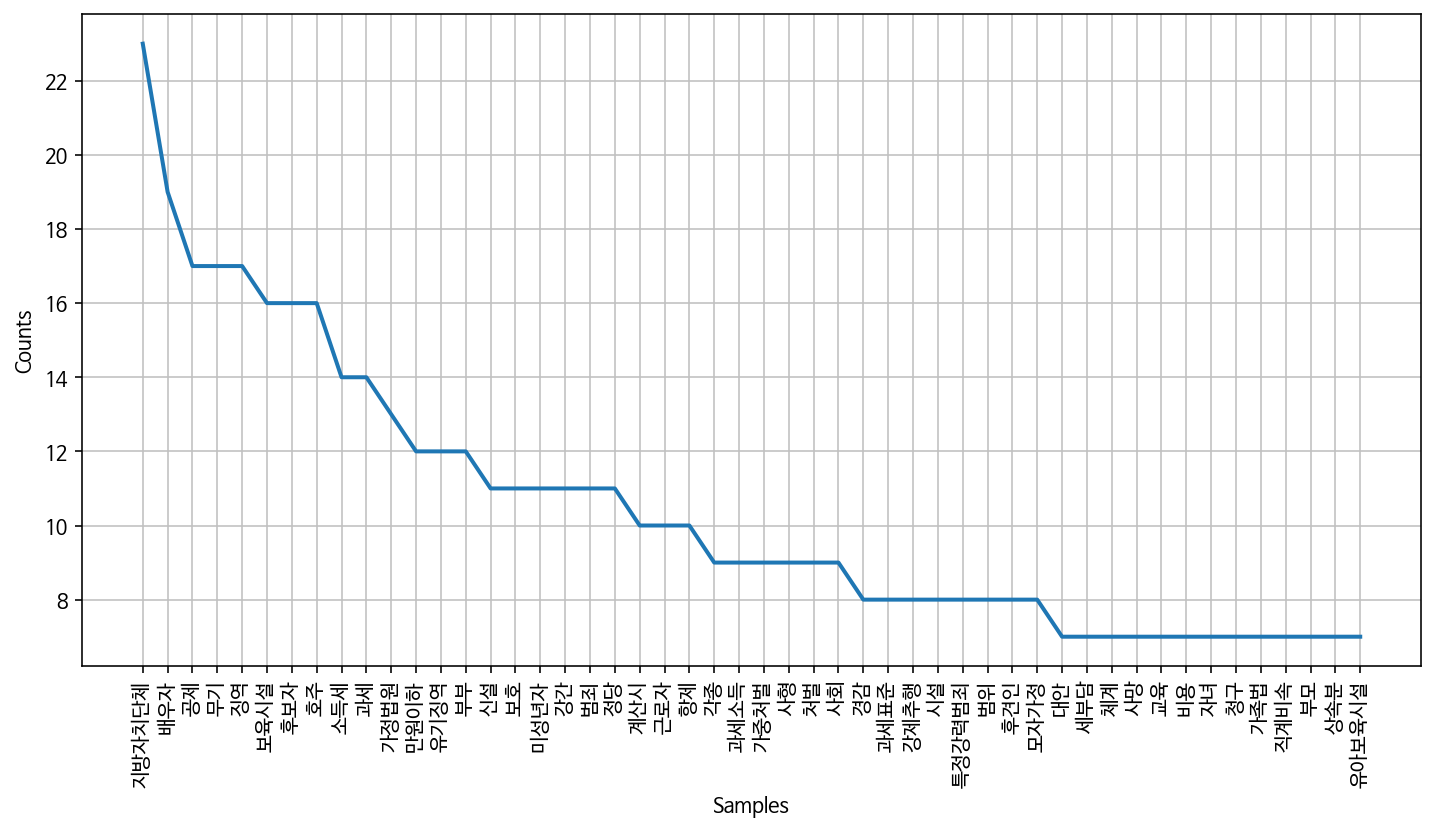

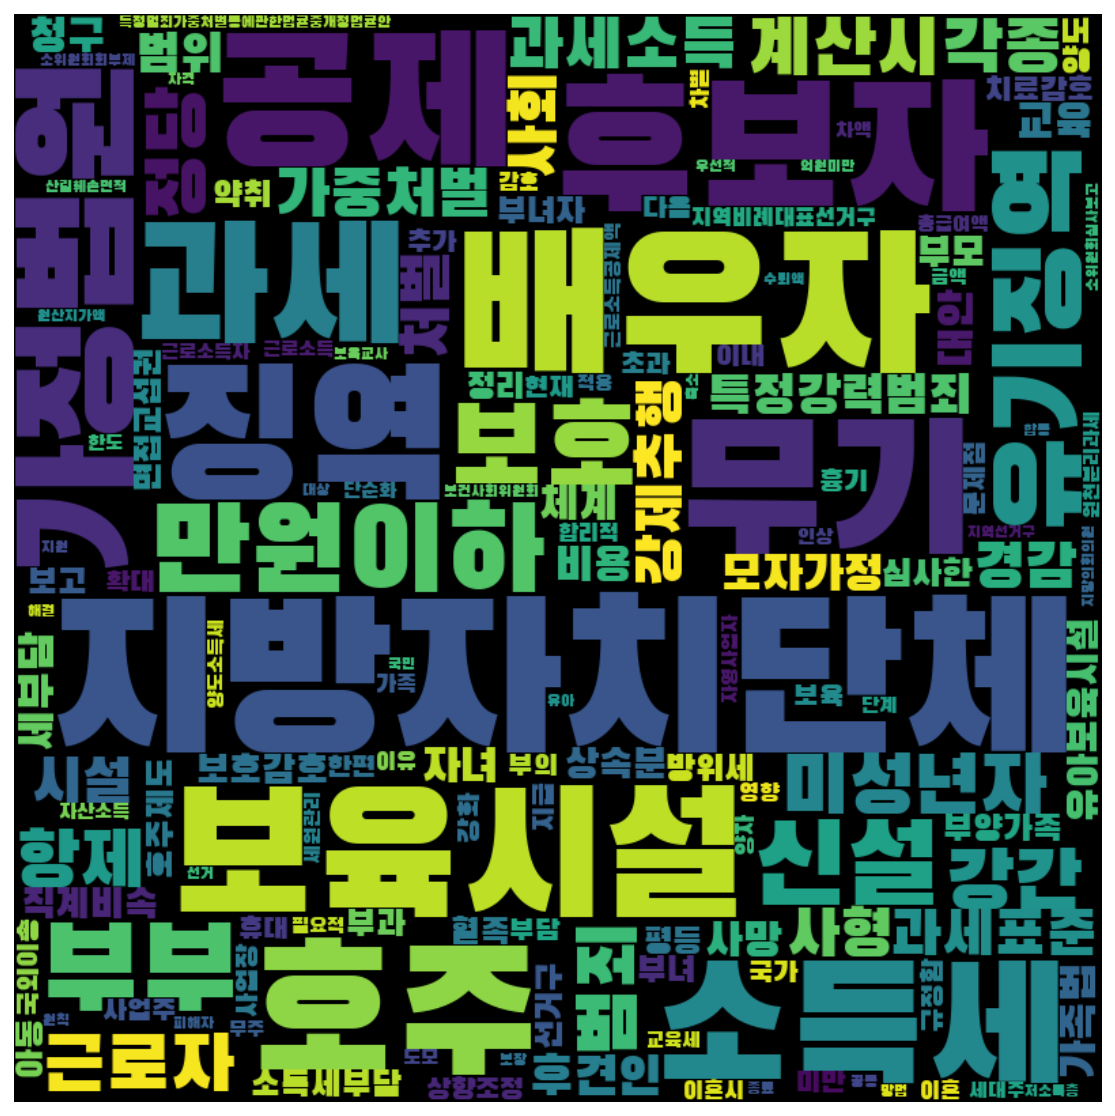

In [26]:
frewords_vis(gender_word)
wordcloud_vis(gender_word)